In [1]:
from sklearn.datasets import make_blobs

def generate_first_dataset():
  X, y = make_blobs(n_samples=150,
    n_features=2,
    centers=10,
    cluster_std=0.5,
    shuffle=True,
    random_state=42)
  
  return X, y


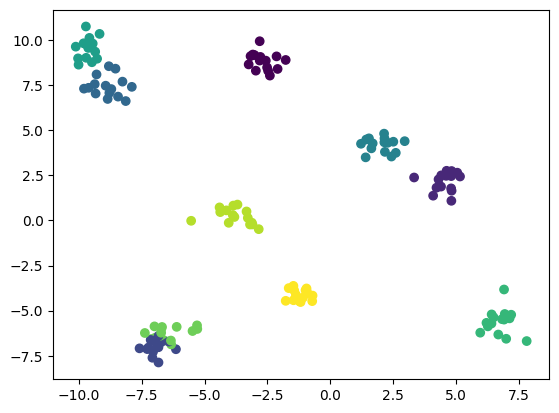

In [2]:

import matplotlib.pyplot as plt

# generowanie zbioru danych
X, y = generate_first_dataset()

# wyświetlenie wygenerowanego zbioru danych z podziałem na klastry
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.show()



### Technika *zasady łokcia*

In [3]:
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np

# zakres liczby klastrów
k_values = range(1, 31)

# listy dla średnich miar jakości
avg_rand_scores = []
avg_mutual_info_scores = []

# listy dla odchyleń standardowych miar jakości
std_rand_scores = []
std_mutual_info_scores = []



In [4]:
# klasteryzacja dla kolejnych wartości k
for k in k_values:
  rand_scores = []
  mutual_info_scores = []

  # wielokrotne klasteryzowanie dla tej samej wartości k
  for i in range(10):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=1, random_state=42)
    kmeans.fit(X)

    labels = kmeans.labels_

    rand_scores.append(metrics.adjusted_rand_score(y, labels))
    mutual_info_scores.append(metrics.adjusted_mutual_info_score(y, labels))
  
  # średnia i odchylenie standardowe dla danej wartości k
  avg_rand_scores.append(np.mean(rand_scores))
  avg_mutual_info_scores.append(np.mean(mutual_info_scores))

  std_rand_scores.append(np.std(rand_scores))
  std_mutual_info_scores.append(np.std(mutual_info_scores))


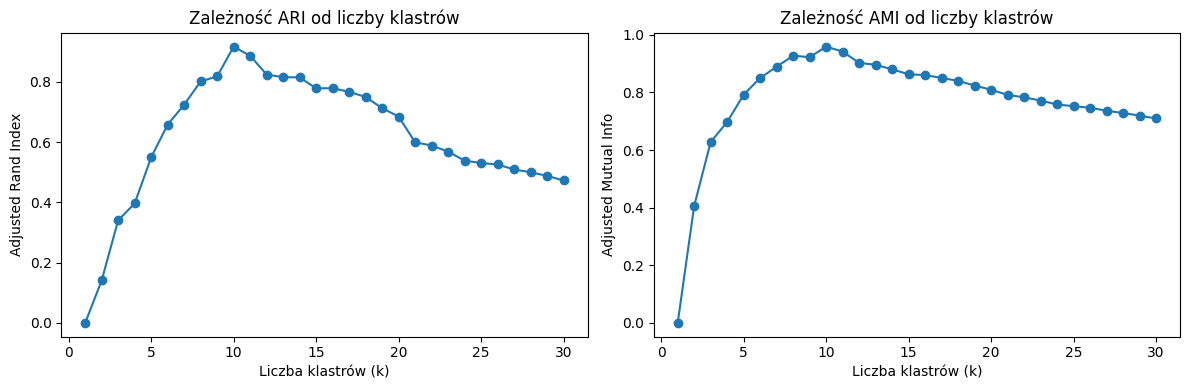

In [5]:
# wykresy zależności miar jakości od liczby klastrów

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(k_values, avg_rand_scores, marker='o')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Adjusted Rand Index')
plt.title('Zależność ARI od liczby klastrów')

plt.subplot(122)
plt.plot(k_values, avg_mutual_info_scores, marker='o')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Adjusted Mutual Info')
plt.title('Zależność AMI od liczby klastrów')

plt.tight_layout()
plt.show()

In [6]:
# Wypisanie uzyskanych wartości k dla każdej miary jakości
best_k_ari = np.argmax(avg_rand_scores) + 1
best_k_ami = np.argmax(avg_mutual_info_scores) + 1

print(f"Najlepsza wartość k dla ARI: {best_k_ari}")
print(f"Najlepsza wartość k dla AMI: {best_k_ami}")


Najlepsza wartość k dla ARI: 10
Najlepsza wartość k dla AMI: 10


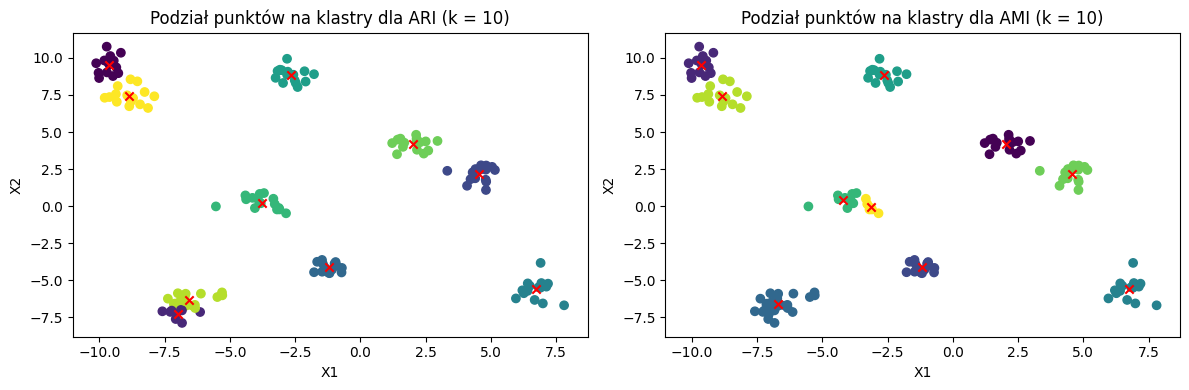

In [7]:
# wykonanie klasteryzacji dla optymalnych wartości k
best_kmeans_ari = KMeans(n_clusters=best_k_ari, init='k-means++', n_init=1)
best_kmeans_ari.fit(X)
labels_ari = best_kmeans_ari.labels_

best_kmeans_ami = KMeans(n_clusters=best_k_ami, init='k-means++', n_init=1)
best_kmeans_ami.fit(X)
labels_ami = best_kmeans_ami.labels_

# Wykres podziału punktów na klastry dla ARI
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=labels_ari, cmap='viridis')
plt.scatter(best_kmeans_ari.cluster_centers_[:, 0], best_kmeans_ari.cluster_centers_[:, 1], c='red', marker='x')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Podział punktów na klastry dla ARI (k = {})'.format(best_k_ari))

# Wykres podziału punktów na klastry dla AMI
plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=labels_ami, cmap='viridis')
plt.scatter(best_kmeans_ami.cluster_centers_[:, 0], best_kmeans_ami.cluster_centers_[:, 1], c='red', marker='x')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Podział punktów na klastry dla AMI (k = {})'.format(best_k_ami))

plt.tight_layout()
plt.show()


- **k** jest takie same w obu przypadkach
- **k** jest zgodne z podanym przy generacji
- Podział na **k** klastry wydaje się, że "ma sens". Wygenerowany zbiór sam posiada lekko nakładające sie klastry, więc powyższy podział jest jak najbardziej poprawny.

### Adaptywne hierarchiczne dobieranie liczby klastrów

In [8]:
from scipy.stats import normaltest

# współczynniki prostej przechodzącej przez dwa punkty
def getLineEquation(p1, p2):
    a = (p2[1] - p1[1]) / (p2[0] - p1[0])
    b = p1[1] - a * p1[0]

    return a, b


# obliczenie odległości punktu od prostej
def getDistanceFromLine(point, line):
    a, b = line
    x, y = point

    return abs(a * x - y + b) / np.sqrt(a**2 + 1)

# rzutowanie punktu na prostą
def getCrossoverPoint(line, point):
    a, b = line
    x, y = point

    x0 = (x + a * y - a * b) / (a**2 + 1)
    y0 = (a * x + a**2 * y - a**2 * b) / (a**2 + 1) + b

    return x0, y0

def getPointBetweenPoints(p1, p2):
    return (p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2


# obliczenie odległości punktu od centroidu (punkty poniżej prostopadłej do prostej przechodzącej przez centroid mają ujemną odległość)
def getDistanceFromCentroid(point, centroid):
    dist = np.sqrt((point[0] - centroid[0])**2 + (point[1] - centroid[1])**2)
    if point[1] < centroid[1]:
        dist = -dist
    
    return dist

# sprawdzenie normalności rozkładu po rzutowaniu na prostą
def check_normality(X, threshold):
    _, p = normaltest(X)
    return p > threshold

# Funkcja do rekurencyjnego podziału klastrów na podklastry
def recursive_cluster_split(X, threshold, min_cluster_size, cluster_iterator=0):
    # jeśli liczba punktów w klastrze jest mniejsza niż minimalny rozmiar klastra, to zwracamy listę zawierającą tylko ten klaster
    if len(X) < min_cluster_size:
        temp_kmeans = KMeans(n_clusters=1, init='k-means++', n_init=1)
        temp_kmeans.fit(X)
        centroid = temp_kmeans.cluster_centers_[0]
        return np.full(len(X), cluster_iterator), [centroid]

    kmeans = KMeans(n_clusters=2, init='k-means++', n_init=1)
    kmeans.fit(X)

    labels = kmeans.labels_
    unique_labels = np.unique(labels) # powinny być dwa
    assert len(unique_labels) == 2

    # centroidy klastrów
    centroids = kmeans.cluster_centers_

    # linia prosta przechodząca przez centroidy
    line = getLineEquation(centroids[0], centroids[1])

    # rzutowanie punktów na prostą
    projected_points = []
    for point in X:
        projected_points.append(getCrossoverPoint(line, point))
    
    # generujemy wspólny środek dla obu klastrów
    center = getPointBetweenPoints(centroids[0], centroids[1])

    # obliczamy odległość każdego punktu od środka
    X_dist = []
    for point in projected_points:
        X_dist.append(getDistanceFromCentroid(point, center))

    # sprawdzamy normalność rozkładu odległości
    if not check_normality(X_dist, threshold):
        X_a = X[labels == unique_labels[0]]
        X_b = X[labels == unique_labels[1]]

        new_cluster_iterator = cluster_iterator * 2 + 1
        labels_a, centroids_a = recursive_cluster_split(X_a, threshold, min_cluster_size, new_cluster_iterator)
        labels_b, centroids_b = recursive_cluster_split(X_b, threshold, min_cluster_size, new_cluster_iterator + 1)

        labels[labels == unique_labels[0]] = labels_a
        labels[labels == unique_labels[1]] = labels_b
        centroids = np.concatenate((centroids_a, centroids_b), axis=0)
    else:
        temp_kmeans = KMeans(n_clusters=1, init='k-means++', n_init=1)
        temp_kmeans.fit(X)
        centroid = temp_kmeans.cluster_centers_[0]
        return np.full(len(X), cluster_iterator), [centroid]
    
    return labels, centroids


[23  7 14 25 27 14 25  8  4 14 25 23  8 26 27  8  7 14 14 14 23  7 25 24
 27  7 27 25  7 14  7 28  4  4 24 27 23 28 23  8  4 24 25 23 28  8 24 14
 14  4  8 27 27  7 24 25 25 25 28  4 24 14 25  7 24 28 28  4  4  8  8 27
 25 25  8 28  8 24 25 24  7 28 23 25 28 25  4 25  8 28 26 23 28  4 23 25
 25 27 24 28 27  7 26 24 25  4  7  4 14 27 25 23 28 23 23 23 27 28 25 14
  8 25  4 24 14  4 24  7 25 25 25  7  7 24 27 14 28 26 25  8  7 24 27  4
  8 23 14 27 23  8]
[[-8.85304934  7.43429612]
 [-9.63718987  9.5454271 ]
 [-2.6575769   8.8278755 ]
 [-1.19321394 -4.11297451]
 [-3.77493217  0.2270966 ]
 [-6.87033917 -6.72867407]
 [-5.54643293 -5.96476965]
 [ 4.5490673   2.15235833]
 [ 2.0183141   4.19715562]
 [ 6.74045364 -5.61808495]]


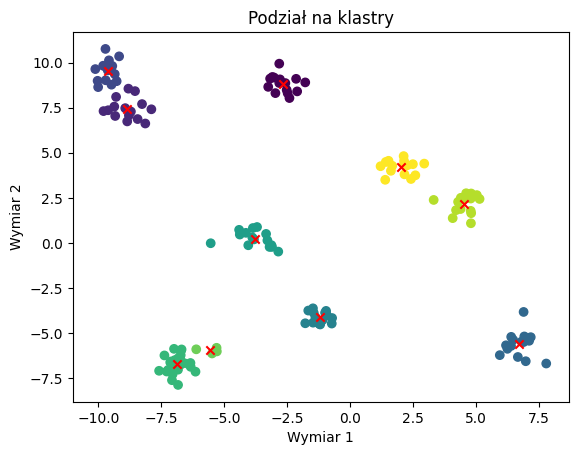

In [9]:
# parametry algorytmu
threshold = 0.05  # prog czułości testu normalności
min_cluster_size = 20  # minimalna liczba punktów w klastrze

# wywołanie rekurencyjnego podziału klastrów
labels, centroids = recursive_cluster_split(X, threshold, min_cluster_size)
print(labels)
print(centroids)

# mapujemy etykiety klastrów na etykiety od 0 do n-1
unique_labels = np.unique(labels)
for i, label in enumerate(unique_labels):
    labels[labels == label] = i


# wykres podziału na klastry
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red')
plt.title("Podział na klastry")
plt.xlabel("Wymiar 1")
plt.ylabel("Wymiar 2")
plt.show()


In [10]:
# wyświetlenie liczby klastrów i ich rozmiarów
unique_labels, cluster_sizes = np.unique(labels, return_counts=True)
num_clusters = len(unique_labels)
print(f"Liczba klastrów: {num_clusters}")
print("Rozmiary klastrów:")
for i, label in enumerate(unique_labels):
    print(f"Klaster {label}: {cluster_sizes[i]}")

# obliczenie wybranych miar jakości
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

true_labels = y  # prawdziwe etykiety klastrów (dla porównania)

rand_index = adjusted_rand_score(true_labels, labels)
mutual_info = adjusted_mutual_info_score(true_labels, labels)

print(f"Adjusted Rand Index: {rand_index}")
print(f"Adjusted Mutual Information: {mutual_info}")


Liczba klastrów: 10
Rozmiary klastrów:
Klaster 0: 15
Klaster 1: 15
Klaster 2: 15
Klaster 3: 15
Klaster 4: 15
Klaster 5: 15
Klaster 6: 26
Klaster 7: 4
Klaster 8: 15
Klaster 9: 15
Adjusted Rand Index: 0.8955494212469939
Adjusted Mutual Information: 0.9549359843878408


### Piłkarzyki

In [37]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# ładujemy dane z pliku
data = pd.read_csv('players.csv', sep=',')

# good columns (38-105)

# wybieramy kolumny od 38 do 105
df = data.iloc[:, 38:105]

df.head()


/tmp/ipykernel_1910/3491461295.py:6: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('players.csv', sep=',')


,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,92.0,91.0,95.0,34.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8,NaN,89+3,89+3,89+3,92,93,93,93,92,93,93,93,91+2,87+3,87+3,87+3,91+2,66+3,64+3,64+3,64+3,66+3,61+3,50+3,50+3,50+3,61+3,19+3
1,92.0,79.0,86.0,44.0,82.0,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,NaN,90+2,90+2,90+2,85,88,88,88,85,86+3,86+3,86+3,84+3,80+3,80+3,80+3,84+3,64+3,66+3,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3
2,94.0,80.0,88.0,34.0,75.0,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11,NaN,90+1,90+1,90+1,88,89,89,89,88,86+3,86+3,86+3,86+3,78+3,78+3,78+3,86+3,63+3,59+3,59+3,59+3,63+3,60+3,53+3,53+3,53+3,60+3,20+3
3,83.0,86.0,94.0,37.0,63.0,85,83,63,86,86,95,88,87,81,95,93,89,96,89,84,80,64,81,53,81,63,37,86,90,93,93,35,32,29,9,9,15,15,11,NaN,83+3,83+3,83+3,90,88,88,88,90,89+2,89+2,89+2,89+2,82+3,82+3,82+3,89+2,67+3,63+3,63+3,63+3,67+3,62+3,50+3,50+3,50+3,62+3,20+3
4,86.0,93.0,88.0,64.0,78.0,94,82,55,94,82,88,85,83,93,91,76,76,79,91,78,91,63,89,74,91,76,66,88,94,83,89,68,65,53,15,13,5,10,13,NaN,83+3,83+3,83+3,88,87,87,87,88,89+2,89+2,89+2,89+2,89+2,89+2,89+2,89+2,79+3,80+3,80+3,80+3,79+3,75+3,69+3,69+3,69+3,75+3,21+3


In [38]:
# sprawdzamy czy są jakieś brakujące wartości
print(df.isnull().sum().to_string())

shooting     2132
passing      2132
dribbling    2132
defending    2132
physic       2132
             ... 
lcb             0
cb              0
rcb             0
rb              0
gk              0
Length: 67, dtype: int64


In [39]:
# usuwamy bramkarzy, bo będą nam przeszkadzać
# usuwamy te wiersze, które posiadają wartości w kolumnie goalkeeping_speed 
df = df[df.goalkeeping_speed.isnull()]

# usuwamy kolumnę goalkeeping_speed, bo jest pusta
df = df.drop(columns=['goalkeeping_speed'])

print(df.isnull().sum().sum())

0


In [40]:
# w kolumnach od 79-105 występują wartości postaci "NUM", "NUM+NUM" lub "NUM-NUM", np. "90+3", "90-2"
# zamieniamy je na wartości numeryczne, które są sumą lub różnicą tych liczb (np. "90+3" -> 93, "90-2" -> 88))
# czyli po prostu wykonujemy operacje arytmetyczne na tych liczbach jeżeli są obecne
# zamieniamy typ kolumny na int
for i in range(39, 66):
    df.iloc[:, i] = df.iloc[:, i].apply(lambda x: eval(x) if type(x) == str else x)
    df[df.columns[i]] = df[df.columns[i]].astype(int)

print(df.iloc[:, 39])

0        92
1        92
2        91
3        86
4        86
         ..
19234    46
19235    47
19236    47
19237    49
19238    47
Name: ls, Length: 17107, dtype: int64


In [15]:
# upewniamy się, że wszystkie kolumny mają poprawny typ
print(df.dtypes.to_string())

shooting                       float64
passing                        float64
dribbling                      float64
defending                      float64
physic                         float64
attacking_crossing               int64
attacking_finishing              int64
attacking_heading_accuracy       int64
attacking_short_passing          int64
attacking_volleys                int64
skill_dribbling                  int64
skill_curve                      int64
skill_fk_accuracy                int64
skill_long_passing               int64
skill_ball_control               int64
movement_acceleration            int64
movement_sprint_speed            int64
movement_agility                 int64
movement_reactions               int64
movement_balance                 int64
power_shot_power                 int64
power_jumping                    int64
power_stamina                    int64
power_strength                   int64
power_long_shots                 int64
mentality_aggression     

In [16]:
from sklearn.metrics import calinski_harabasz_score

# wykorzystujemy pierwsze rozwiązanie z metodą łokcia

# kopiujemy dataframe
X = df.copy()

k_values = range(2, 50)

avg_scores = []
std_scores = []


# klasteryzacja dla kolejnych wartości k
for k in k_values:
  scores = []
  mutual_info_scores = []

  # wielokrotne klasteryzowanie dla tej samej wartości k
  for i in range(10):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=1, random_state=42)
    kmeans.fit(X)

    labels = kmeans.labels_

    scores.append(calinski_harabasz_score(X, labels))
  
  # średnia i odchylenie standardowe dla danej wartości k
  avg_scores.append(np.mean(scores))
  std_scores.append(np.std(scores))


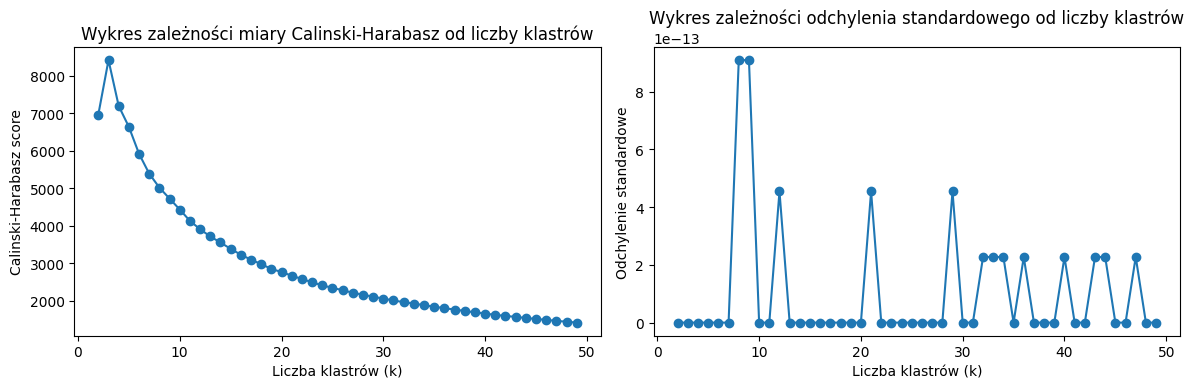

In [17]:
# wykresy zależności miar jakości od liczby klastrów

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(k_values, avg_scores, marker='o')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Calinski-Harabasz score')
plt.title('Wykres zależności miary Calinski-Harabasz od liczby klastrów')

plt.subplot(1, 2, 2)

plt.plot(k_values, std_scores, marker='o')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Odchylenie standardowe')
plt.title('Wykres zależności odchylenia standardowego od liczby klastrów')

plt.tight_layout()
plt.show()

In [18]:
# Wypisanie uzyskanych wartości k dla każdej miary jakości
best_k = np.argmax(avg_scores) + 2 # (zaczynalismy sprawdzac od 2)

print(f"Najlepsza wartość k dla miary Calinski-Harabasz: {best_k}")

Najlepsza wartość k dla miary Calinski-Harabasz: 3


In [33]:
X = df.copy()

k_means = KMeans(n_clusters=best_k, init='k-means++', n_init=1, random_state=42)
k_means.fit(X)

labels = k_means.labels_

unique_labels, cluster_sizes = np.unique(labels, return_counts=True)

print(f"Liczba klastrów: {len(unique_labels)}")
print(f"Rozmiary klastrów: {cluster_sizes}")
print()

# usuwamy bramkarzy, bo będą nam przeszkadzać
data_nogk = data[data.goalkeeping_speed.isnull()]
data_nogk = data_nogk.drop(columns=['goalkeeping_speed'])

# pokazujemy ilość "player_positions" dla każdego klastra
for i in range(len(unique_labels)):
  print(f"Klaster {i}:")
  print(data_nogk[labels == i].player_positions.value_counts().head(10))
  print()

Liczba klastrów: 3
Rozmiary klastrów: [5621 5433 6053]

Klaster 0:
player_positions
ST         1679
LM          170
CAM         167
RM          158
RM, LM      157
LM, RM      139
CAM, CM     122
ST, LW      106
RW           97
ST, LM       93
Name: count, dtype: int64

Klaster 1:
player_positions
CB         2187
RB          334
LB          328
CB, RB      254
CDM, CM     253
CM          226
CDM         173
CB, LB      172
CB, CDM     154
RB, CB       89
Name: count, dtype: int64

Klaster 2:
player_positions
CDM, CM    700
CM, CDM    586
CM         421
LB         287
RB         242
CB         236
CM, CAM    158
LB, LM     126
CAM, CM    124
CDM        120
Name: count, dtype: int64



Podział nawet dobry. Podzielił zawodników na atakujących, środkowych i broniących. To, że niektórzy pojawili się w innych grupach wynika prawdopodobnie z tego, że pewne ich statystyki mogły być zbliżone do tych z innych grup. Trzeba pamiętać, że same liczby nie odzwierciedlają umiejętności zawodnika, a jedynie jego statystyki.

In [34]:
# stosujemy PCA i redukujemy wymiarowość do 2
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(df)


[38 38 38 ... 58 45 93]
[[ 4.53097761e+01  2.43794933e+01]
 [ 3.53027515e+01  3.30920230e+01]
 [ 1.39857974e+01  1.19248264e+01]
 [ 2.11176463e+01  3.57009454e+00]
 [ 3.22015779e+01  1.64346524e+01]
 [ 3.69137603e+01  1.17378499e+01]
 [ 2.85866615e+01  1.00038132e+01]
 [ 2.35725392e+01  2.08938204e+01]
 [ 6.26599863e+01  5.13333316e+00]
 [ 5.20848380e+01  1.25579664e+01]
 [ 2.85556049e+01 -4.58644860e+00]
 [ 3.88031087e+01  1.48196583e+00]
 [ 4.53170655e+01 -1.02715968e+01]
 [ 9.43049867e+01  4.05832327e+01]
 [ 8.92911335e+01  5.90766710e+01]
 [ 8.04659094e+01  4.57658356e+01]
 [ 7.36738726e+01  1.70677716e+01]
 [ 7.87374178e+01  2.40905003e+01]
 [ 8.37533453e+01  2.93853120e+01]
 [ 6.80920735e+01  3.16984229e+01]
 [ 4.57886835e+01  4.38651833e+01]
 [ 5.29043268e+01  5.20673854e+01]
 [ 6.20290486e+01  4.50664688e+01]
 [ 5.55875218e+01  3.56124927e+01]
 [ 7.48492248e+01  6.75551600e+01]
 [ 6.85143593e+01  5.45351615e+01]
 [ 5.78018021e+01  5.89838252e+01]
 [ 6.23600582e+01  6.38380693e+

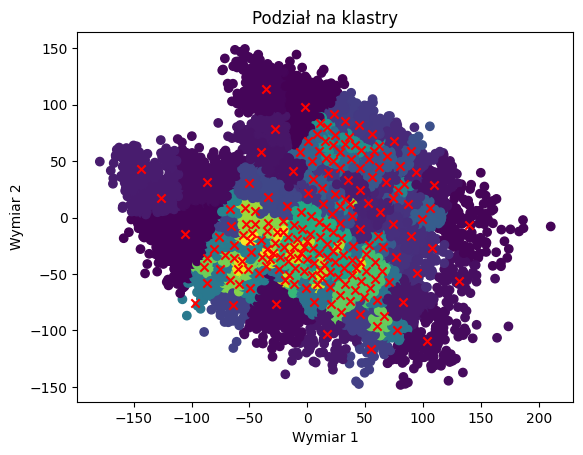

In [35]:
# stosujemy drugą metodę

threshold = 0.00001  # prog czułości testu normalności
min_cluster_size = 20  # minimalna liczba punktów w klastrze

# wywołanie rekurencyjnego podziału klastrów
labels, centroids = recursive_cluster_split(X, threshold, min_cluster_size)
print(labels)
print(centroids)

# mapujemy etykiety klastrów na etykiety od 0 do n-1
unique_labels = np.unique(labels)
for i, label in enumerate(unique_labels):
    labels[labels == label] = i


# wykres podziału na klastry
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red')
plt.title("Podział na klastry")
plt.xlabel("Wymiar 1")
plt.ylabel("Wymiar 2")
plt.show()


In [36]:
# pokazujemy ilość "player_positions" dla każdego klastra
for i in range(len(unique_labels)):
  print(f"Klaster {i}:")
  print(data_nogk[labels == i].player_positions.value_counts().head(10))
  print()

Klaster 0:
player_positions
ST        330
LM         34
RW         30
ST, LW     22
RM         22
RM, LM     18
LW         15
ST, LM     15
LM, RM     15
RM, ST     14
Name: count, dtype: int64

Klaster 1:
player_positions
CB         754
CB, RB      72
CB, LB      44
CB, CDM     41
LB          25
RB          20
LB, CB      13
RB, CB      13
CDM, CB      5
CB, CM       4
Name: count, dtype: int64

Klaster 2:
player_positions
ST             24
ST, LW          5
LM, ST          4
RM, RW          4
CF, ST          4
RW, RM          4
RW              4
RM, LM          4
CF, ST, CAM     3
ST, CF          3
Name: count, dtype: int64

Klaster 3:
player_positions
ST        180
RM         27
RW         18
LM         16
LW         11
ST, RW      9
LM, RM      8
ST, LM      7
CAM         6
LM, ST      6
Name: count, dtype: int64

Klaster 4:
player_positions
CB            197
CB, LB         27
CB, RB         26
CDM, CM        16
CB, CDM        13
CDM            11
RB              7
CDM, CB         